# Publishing Figures - Single Kappa
This obtains all figures for a comparison between two simulations of neighbouring optical depth that only require the surface variables.

In [10]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_delta_temp_quant_theory_simple2, get_delta_temp_quant_theory, decompose_temp_adiabat_anomaly
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [118]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
color_seq_exp = ['b', 'g', 'r']
exp_names = ['Aquaplanet', 'Evap', 'Bucket']
exp_dir = ['tau_sweep/aquaplanet/depth=1/', 'tau_sweep/land/meridional_band/depth=1/evap/',
           'tau_sweep/land/meridional_band/depth=1/bucket_evap/']
color_seq_exp = ['b', 'g', 'r']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
n_kappa = len(kappa_names)
ds = [[] for i in range(n_exp)]
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[i] + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
            
            ds[i] += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
            namelist = isca_tools.load_namelist(exp_dir[i] + kappa_names[j])  # Need this for albedo_value
            if i == 0:
                albedo += [namelist['mixed_layer_nml']['albedo_value']]
                tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
                tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0][0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0][0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0][0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [105]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

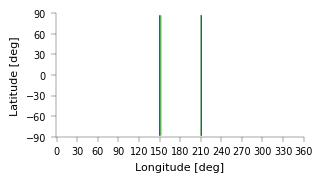

In [106]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir[1], kappa_names[0], 'land.nc')
# isca_tools.plot.show_land(land_file_name)
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

if save_fig or save_land_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [158]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 


lat_use_ind = np.where((np.abs(ds[0][0].lat) <= lat_max) & (np.abs(ds[0][0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0][0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_mean = np.zeros((n_exp, n_kappa, n_pressure, n_lat))
r_mean = np.zeros((n_exp, n_kappa, n_lat))          # compute mean rh as mean over rh on each day
z_mean = np.zeros((n_exp, n_kappa, n_pressure, n_lat))

ds_all = [[] for i in range(n_exp)]
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds[i][j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
            
            if 'aqua' not in exp_names[i].lower():
                # if not aquaplanet, then is land and only consider land longitudes
                ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
            
            if season == 'summer':
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all[i] += [ds_use.load()]
            
            if mean_method == 'all':
                ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
                ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            elif mean_method != 'land':
                raise ValueError(f'Mean method is {mean_method} which is not valid.')
            temp_mean[i, j] = ds_use.temp.mean(dim='lon_time')
            z_mean[i, j] = ds_use.height.mean(dim='lon_time')
            rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
            r_mean[i, j] = rh_use.mean(dim='lon_time')
            pbar.update(1)
sphum_mean = r_mean * sphum_sat(temp_mean[:, :, ind_surf], p_surface)       # compute sphum_mean from r_mean

100%|██████████| 6/6 [00:35<00:00,  5.94s/it]


In [159]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_exp, n_kappa, n_pressure, n_lat, n_quant))
# relative humidity as function of temp quantile not temp quantile
r_quant3 = np.zeros((n_exp, n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_exp, n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_exp, n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_exp, n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_exp, n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_exp*n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds_all[i][j]
            temp_quant3[i, j] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose('pfull', 'lat', 'quantile')
            rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
            is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
            for k in range(n_lat):
                for q, quant in enumerate(quant_plot):
                    use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                    z_quant3[i, j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                    r_quant3[i, j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                    convflag_quant3[i, j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                    pbar.update(1)
sphum_quant3 = sphum_sat(temp_quant3[:, :, ind_surf], p_surface) * r_quant3             # compute specific humidity from relative humidity

100%|██████████| 10692/10692 [00:32<00:00, 324.18it/s]


In [160]:
temp_adiabat_anom = np.zeros((n_exp, n_kappa, n_lat, n_quant))
temp_ce_mean = np.zeros((n_exp, n_kappa, n_lat))
temp_ce_quant = np.zeros((n_exp, n_kappa, n_lat, n_quant))
temp_ft_anom = np.zeros((n_exp, n_kappa, n_lat, n_quant))
for i in range(n_exp):
    for j in range(n_lat):
        temp_adiabat_anom[i, :, j], temp_ce_mean[i, :, j], temp_ce_quant[i, :, j], temp_ft_anom[i, :, j] = \
            decompose_temp_adiabat_anomaly(temp_mean[i, :, ind_surf, j], temp_quant3[i, :, ind_surf, j], sphum_mean[i, :, j], 
                                           sphum_quant3[i, :, j], temp_mean[i, :, ind_ft, j], temp_quant3[i, :, ind_ft, j], 
                                           p_surface, pressure_ft_actual)
z_ft_mod_anom = (z_quant3[:, :, ind_ft] - z_mean[:, :, ind_ft][:, :, :, np.newaxis]) * g / lnp_const 
temp_adiabat_anom_quant3_z_form = z_ft_mod_anom + np.expand_dims(temp_ce_mean, axis=-1) - temp_ce_quant

## Theoretical Temperature Change
Below, we plot whether the theory can correctly predict the temperature change between adjacent simulations.

In [161]:
delta_temp_theory = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ['best', 'wtg_r', 'z_r', 'wtg_q', 'z_q']}
delta_temp_theory_prefactors = {key: np.zeros((n_exp, n_lat, n_quant)) for key in ['temp_s', 'humidity', 'r_change', 'temp_a_change']}
delta_temp_theory_prefactors = {key: copy.deepcopy(delta_temp_theory_prefactors) for key in ['wtg_r', 'z_r', 'wtg_q', 'z_q']}
delta_temp_theory_changes = copy.deepcopy(delta_temp_theory_prefactors)
delta_temp_theory_cont = copy.deepcopy(delta_temp_theory_prefactors)

with tqdm(total=n_exp*n_lat*len(delta_temp_theory), position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_lat):
            delta_temp_theory['best'][i, j]= \
                    get_delta_temp_quant_theory(temp_mean[i, :, ind_surf, j], temp_quant3[i, :, ind_surf, j], sphum_mean[i, :, j],
                                                sphum_quant3[i, :, j], p_surface, pressure_ft_actual, None, None, None, None, 
                                                'squared', 'squared', 'full')[0]
            pbar.update(1)
            for key in ['wtg_r', 'z_r', 'wtg_q', 'z_q']:
                delta_temp_theory[key][i, j], info_coef, info_change = \
                    get_delta_temp_quant_theory_simple2(temp_mean[i, :, ind_surf, j], temp_quant3[i, :, ind_surf, j], sphum_mean[i, :, j],
                                                        sphum_quant3[i, :, j], p_surface, pressure_ft_actual, 
                                                        temp_mean[i, :, ind_ft, j] if 'z' in key else None,
                                                        temp_quant3[i, :, ind_ft, j] if 'z' in key else None, 
                                                        z_mean[i, :, ind_ft, j] if 'z' in key else None, 
                                                        z_quant3[i, :, ind_ft, j] if 'z' in key else None, use_sphum_anom0='q' in key)
                for var in info_coef:
                    delta_temp_theory_prefactors[key][var][i, j] = info_coef[var]
                    delta_temp_theory_changes[key][var][i, j] = info_change[var]
                    delta_temp_theory_cont[key][var][i, j] = info_coef[var] * info_change[var]
                pbar.update(1)
delta_temp_s_mean = delta_temp_theory_changes['wtg_r']['temp_s'][:, :, 0]

100%|██████████| 270/270 [00:07<00:00, 34.02it/s]


In [162]:
delta_temp_ce_mean = temp_ce_mean[:, 1] - temp_ce_mean[:, 0]
delta_temp_ce_quant = temp_ce_quant[:, 1] - temp_ce_quant[:, 0]
delta_temp_ft_anom = temp_ft_anom[:, 1] - temp_ft_anom[:, 0]
delta_z_ft_mod_anom = z_ft_mod_anom[:, 1] - z_ft_mod_anom[:, 0]       
for key in delta_temp_theory_cont:
    delta_temp_theory_cont[key]['temp_ce_change'] = delta_temp_theory_prefactors[key]['temp_a_change'] * \
                                                        (delta_temp_ce_mean[:, :, np.newaxis] - delta_temp_ce_quant)
    if 'z' in key:
        delta_temp_theory_cont[key]['temp_ft_change'] = delta_temp_theory_prefactors[key]['temp_a_change'] * delta_z_ft_mod_anom
    else:
        delta_temp_theory_cont[key]['temp_ft_change'] = delta_temp_theory_prefactors[key]['temp_a_change'] * delta_temp_ft_anom

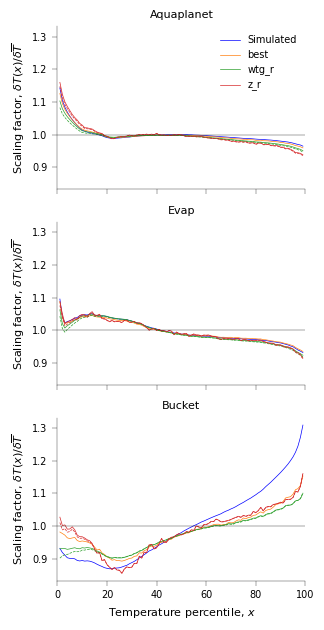

In [163]:
save_scale_factor_fig = False
fig, ax = plt.subplots(n_exp,1, figsize=(width['one_col'], n_exp*width['one_col']/ar), sharex=True, sharey=True)
colors_use = [default_colors[1], default_colors[2], default_colors[3], default_colors[2], default_colors[3]]
for i in range(n_exp):
    ax[i].plot(quant_plot, np.average((temp_quant3[i, 1, ind_surf]-temp_quant3[i, 0, ind_surf])/delta_temp_s_mean[i, :, np.newaxis], 
                                      axis=0, weights=lat_weights), label = 'Simulated', color='b')
    for j, key in enumerate(delta_temp_theory):
        ax[i].plot(quant_plot, np.average(delta_temp_theory[key][i]/delta_temp_s_mean[i, :, np.newaxis], weights=lat_weights, axis=0),
                   color=colors_use[j], label=key if key[-1] != 'q' else None, linestyle='--' if key[-1]=='q' else '-')
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_title(exp_names[i])
    ax[i].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[0].legend()
ax[0].set_xlim([0, 100])
ax[-1].set_xlabel(percentile_label)

if save_fig or save_scale_factor_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/scale_factor_land_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

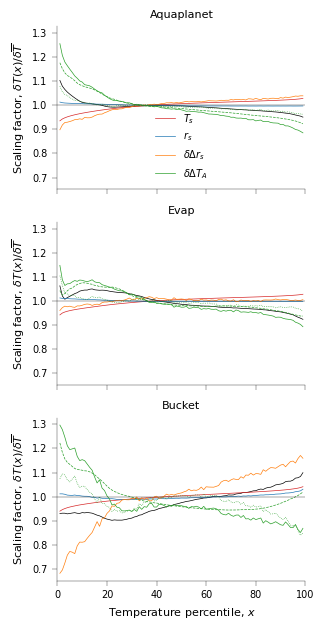

In [164]:
exp_plot = 'wtg_r'
colors_breakdown = {'temp_s': default_colors[3], 'humidity': default_colors[0],  
                    'r_change': default_colors[1], 'temp_a_change': default_colors[2], 
                    'temp_ce_change': default_colors[2], 'temp_ft_change': default_colors[2]}
linestyles_breakdown = {key: '-' for key in colors_breakdown}
linestyles_breakdown['temp_ce_change'] = ':'
linestyles_breakdown['temp_ft_change'] = '--'
labels_breakdown = {'temp_s': '$T_s$', 'humidity': f'${exp_plot[-1]}_s$', 'r_change': '$\delta \Delta r_s$',
                    'temp_a_change': '$\delta \Delta T_A$',
                    'temp_ce_change': None, 'temp_ft_change': None}

save_sf_theory_breakdown_fig = False
fig, ax = plt.subplots(n_exp,1, figsize=(width['one_col'], n_exp*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].plot(quant_plot, np.average(delta_temp_theory[exp_plot][i]/delta_temp_s_mean[i, :, np.newaxis], axis=0, weights=lat_weights), color='k')
    for key in delta_temp_theory_cont[exp_plot]:
        ax[i].plot(quant_plot, np.average(delta_temp_theory_cont[exp_plot][key][i]/delta_temp_s_mean[i, :, np.newaxis],
                                          weights=lat_weights, axis=0)+1, color=colors_breakdown[key], 
                   linestyle=linestyles_breakdown[key], label=labels_breakdown[key])
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
    ax[i].set_title(exp_names[i])
ax[0].legend()
ax[0].set_xlim(0,100)
ax[-1].set_xlabel(percentile_label)

if save_fig or save_sf_theory_breakdown_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/scale_factor_land_breakdown_{exp_plot}_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\Delta T_A$ for each simulation
To help understand the bottom plot above, I see how $T_{CE}(x)$ and $\Delta T_{FT}(x)$ vary with warming below.

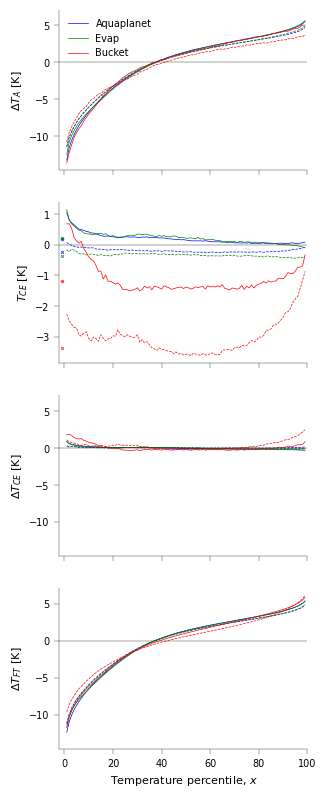

In [165]:
save_temp_adiabat_fig = False
use_temp_adiabat_z_form = False
linestyles_kappa = ['-', '--']

fig, ax = plt.subplots(4,1, figsize=(width['one_col'], 4*width['one_col']/ar), sharex=True)
ax[0].sharey(ax[2])
ax[2].sharey(ax[3])
for i in range(n_exp):
    for j in range(n_kappa):
        if use_temp_adiabat_z_form:
            ax[0].plot(quant_plot, np.average(temp_adiabat_anom_quant3_z_form[i], axis=0, weights=lat_weights), color=color_seq_exp[i],
                       linestyle=linestyles_kappa[j], label=exp_names[i] if j==0 else None)
            ax[3].plot(quant_plot, np.average(z_ft_mod_anom[i, j], axis=0, weights=lat_weights), color=color_seq_exp[i],
                       linestyle=linestyles_kappa[j])
        else:
            ax[0].plot(quant_plot, np.average(temp_adiabat_anom[i, j], axis=0, weights=lat_weights), color=color_seq_exp[i], 
                       linestyle=linestyles_kappa[j], label=exp_names[i] if j==0 else None)
            ax[3].plot(quant_plot, np.average(temp_ft_anom[i, j], axis=0, weights=lat_weights), color=color_seq_exp[i], linestyle=linestyles_kappa[j])
        ax[1].plot(quant_plot, np.average(temp_ce_quant[i, j], axis=0, weights=lat_weights), color=color_seq_exp[i], linestyle=linestyles_kappa[j])
        ax[1].scatter(-1, np.average(temp_ce_mean[i, j], axis=0, weights=lat_weights), marker='o' if j==0 else 'X', alpha=0.7, edgecolors=None,
                      facecolors=color_seq_exp[i], lw=0)
        ax[2].plot(quant_plot, np.average((temp_ce_quant[i, j]-temp_ce_mean[i, j, :, np.newaxis]), axis=0, weights=lat_weights), 
                   color=color_seq_exp[i], linestyle=linestyles_kappa[j])
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(-2, 100)
ax[1].set_ylabel('$T_{CE}$ [K]')
ax[2].set_ylabel('$\Delta T_{CE}$ [K]')
if use_temp_adiabat_z_form:
    ax[0].set_ylabel("$\Delta T_A'$ [K]")
    ax[3].set_ylabel('$\\frac{g}{R^{\dagger}}\Delta z_{FT}$ [K]')
else:
    ax[0].set_ylabel('$\Delta T_A$ [K]')
    ax[3].set_ylabel('$\Delta T_{FT}$ [K]')
ax[-1].set_xlabel(percentile_label)
# label_subplots(fig, ax, ['a)', 'c)', 'e)', 'g)'] if season == 'summer' else ['b)', 'd)', 'f)', 'h)'], box_alpha=0)
# ax[0].set_ylim(-13, 13)
# ax[1].set_ylim(-2, 19)
ax[0].legend()
# ax[0].legend(title='$\kappa$', fontsize=4.5, loc='lower right')
if save_fig or save_temp_adiabat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_adiabat_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Near-surface Anomalies
The temperature and relative humidity anomalies influence the theory directly. Below, I look at these.

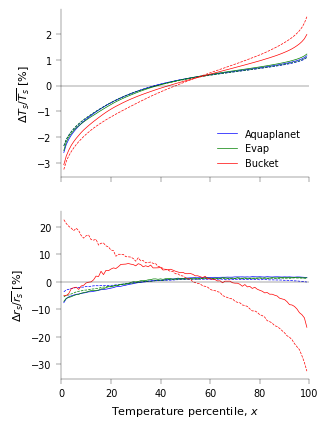

In [166]:
save_near_surf_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    for j in range(n_kappa):
        ax[0].plot(quant_plot, 100*np.average((temp_quant3[i, j, ind_surf]-temp_mean[i, j, ind_surf, :, np.newaxis]
                                               )/temp_mean[i, j, ind_surf, :, np.newaxis], axis=0, weights=lat_weights),
                   color=color_seq_exp[i], linestyle=linestyles_kappa[j], label=exp_names[i] if j==0 else None)
        ax[1].plot(quant_plot, 100*np.average((r_quant3[i, j]-r_mean[i, j, :, np.newaxis]
                                               )/r_mean[i, j, :, np.newaxis], axis=0, weights=lat_weights),
                   color=color_seq_exp[i], linestyle=linestyles_kappa[j])
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[-1].set_xlabel(percentile_label)
ax[0].set_ylabel("$\Delta T_s/\overline{T_s}$ [%]")
ax[1].set_ylabel("$\Delta r_s/\overline{r_s}$ [%]")
ax[0].legend(frameon=True, framealpha=1, edgecolor='white',title_fontsize=7, loc='lower right')
ax[1].set_ylim([ax[1].get_ylim()[0], ax[1].get_ylim()[1]+0.5])
ax[0].set_xlim(0, 100)
# label_subplots(fig, ax, ['a)', 'c)'] if season == 'summer' else ['b)', 'd)'], box_alpha=0)

if save_fig or save_near_surf_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/surface_anomalies_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Convective days as function of $x$ for each $\kappa$
We expect the amount of days convecting to increase with surface temperature. Below, we see that this assumption breaks down for the hottest simulations.

A day is convecting if `convflag>1` (at least shallow convection) and $LNB<486hPa$. The percentage of days that satisfy this is shown in the second plot below.

In [167]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(pfull)), pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

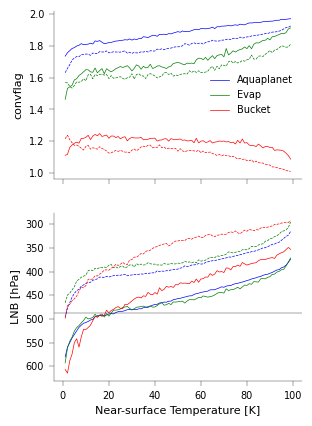

In [168]:
save_convflag_fig = False
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2 * width['one_col'] / ar), sharex=True)
for i in range(n_exp):
    for j in range(n_kappa):
        ax[0].plot(quant_plot, np.average(convflag_quant3[i, j], axis=0, weights=lat_weights), 
                   color=color_seq_exp[i], linestyle=linestyles_kappa[j], label=exp_names[i] if j==0 else None)
        ax[1].plot(quant_plot, lzb(np.average(klzbs_quant3[i, j], axis=0, weights=lat_weights)), 
                   color=color_seq_exp[i], linestyle=linestyles_kappa[j])
ax[1].axhline(pressure_ft_actual/100, color='k', lw=ax_linewidth)
ax[0].legend()
ax[0].set_ylabel('convflag')
ax[-1].set_xlabel('Near-surface Temperature [K]')
ax[1].invert_yaxis()
ax[1].set_ylabel('LNB [hPa]')
# ax.set_ylim(1, 2)
if save_convflag_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convflag_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

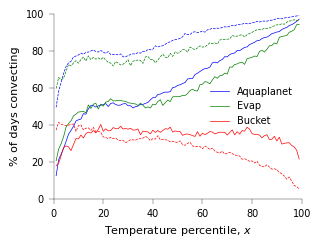

In [169]:
save_convfract_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
for i in range(n_exp):
    for j in range(n_kappa):
        ax.plot(quant_plot, 100 * np.average(convfract_quant3[i, j], axis=0, weights=lat_weights),
                color=color_seq_exp[i], linestyle=linestyles_kappa[j], label=exp_names[i] if j==0 else None)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_ylabel('% of days convecting')
ax.legend()
# ax.legend(title='$\kappa$')
if save_convfract_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convfract_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)